# INFO 2950 Project Phase 2
#### Talia Boehm, Lucy Barsanti, Emma Shen, Maddi Klancher


Link to dataset: https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp

In [2]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup

import seaborn
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression

In [3]:
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

## I. Research Question

### A. Instructions from student handbook 
State your research question (s) clearly.


## II. Data Collection and Cleaning
### A. Instructions from student handbook 

- Have an initial dra of your data cleaning
appendix. 
- Document every step that takes your raw data file(s) and turns it into the analysis-ready data set that you would submit with your final project. 
- Include text cells describing your data collection (downloading, Rescraping, surveys, etc), and text cells describing any additional data curation/cleaning (merging data frames, filtering, transformations of
variables, etc). 
- Include code cells for data curation/cleaning, but not
collection. 
- *Note:* You should be saving data in intermediate files at several points through this process so that you are not starting from scratch every time you change something. This also makes sure you have documentation for everything that you have done for your reference, but we do not necessarily need to see all of it in code form.

### Our work here

We are using the Flight Delay from January 2017 - July 2022 dataset that we found from the Bureau of Transportation Statistics website. 

Link to dataset: "https://drive.google.com/file/d/1Ci4XzBpg3BF-_zx70sBTN1uVkaERmTgl/view?usp=sharing "


## III. Data Description

### A. Instructions from student handbook
Have an initial dra of your data description section.
Your data description should be about your analysis-ready data.


The dataset contains information on flights in the United States from January 2017 to July 2022. The data includes the date, flight number, origin airport, destination airport, departure time, arrival time, and the reason for any delays.

## IV. Data Limitation
### A. Instructions from student handbook 
Have an initial dra of your data description section.

Identify any potential problems with your dataset.

## V. Exploratory Data Analysis 
### A. Instructions from student handbook
Have an initial dra of your data description section.
Perform and initial exploratory data analysis 

In [4]:
df_delays = pd.read_csv('Airline_Delay_Cause.csv')
df_delays.head()

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2022,7,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",33.0,2.0,0.92,1.00,...,0.0,0.00,0.0,0.0,129.0,98.0,23.0,8.0,0.0,0.0
1,2022,7,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",78.0,25.0,11.80,0.72,...,0.0,7.48,0.0,0.0,1664.0,887.0,52.0,224.0,0.0,501.0
2,2022,7,9E,Endeavor Air Inc.,ACK,"Nantucket, MA: Nantucket Memorial",124.0,19.0,5.84,1.00,...,0.0,5.40,5.0,4.0,1523.0,388.0,35.0,511.0,0.0,589.0
3,2022,7,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",67.0,10.0,1.32,1.00,...,1.0,4.28,0.0,1.0,657.0,103.0,82.0,93.0,25.0,354.0
4,2022,7,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",174.0,30.0,18.10,5.75,...,0.0,2.55,1.0,0.0,2462.0,1686.0,310.0,139.0,0.0,327.0


In [5]:
df_covid = pd.read_csv('Covid-by-State.csv')
df_covid['submission_date']= pd.to_datetime(df_covid['submission_date'])
df_covid['year'] = pd.DatetimeIndex(df_covid['submission_date']).year
df_covid['month'] = pd.DatetimeIndex(df_covid['submission_date']).month
df_covid.head()

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths,year,month
0,2021-03-11,KS,297229,241035.0,56194.0,0,0.0,4851,NaN,NaN,0,0.0,03/12/2021 03:20:13 PM,Agree,NaN,2021,3
1,2021-12-01,ND,163565,135705.0,27860.0,589,220.0,1907,NaN,NaN,9,0.0,12/02/2021 02:35:20 PM,Agree,Not agree,2021,12
2,2022-01-02,AS,11,NaN,NaN,0,0.0,0,NaN,NaN,0,0.0,01/03/2022 03:18:16 PM,NaN,NaN,2022,1
3,2021-11-22,AL,841461,620483.0,220978.0,703,357.0,16377,12727.0,3650.0,7,3.0,11/22/2021 12:00:00 AM,Agree,Agree,2021,11
4,2022-05-30,AK,251425,NaN,NaN,0,0.0,1252,NaN,NaN,0,0.0,05/31/2022 01:20:20 PM,NaN,NaN,2022,5


In [6]:

%sql df_covid_cleaned << SELECT year, month, state, SUM(tot_cases) AS tot_case, SUM(new_case) AS new_case FROM df_covid GROUP BY state, month, year ORDER BY year, month, state ASC

df_covid_cleaned


Returning data to local variable df_covid_cleaned


,year,month,state,tot_case,new_case
0,2020,1,AK,0,0
1,2020,1,AL,0,0
2,2020,1,AR,0,0
3,2020,1,AS,0,0
4,2020,1,AZ,6,1
...,...,...,...,...,...
2035,2022,10,VT,2394457,1530
2036,2022,10,WA,32827982,12770
2037,2022,10,WI,33758028,17572
2038,2022,10,WV,10850608,4454


In [16]:
## MADDI
%sql Endeavor_ABE_22_df << SELECT * FROM df_delays WHERE carrier = '9E' AND airport = 'ABE' AND year = 2022
Endeavor_ABE_22_df.head()

Returning data to local variable Endeavor_ABE_22_df


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2022,7,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",33.0,2.0,0.92,1.00,...,0.00,0.00,0.0,0.0,129.0,98.0,23.0,8.0,0.0,0.0
1,2022,6,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",133.0,14.0,9.28,0.03,...,0.00,3.04,3.0,0.0,853.0,625.0,2.0,56.0,0.0,170.0
2,2022,5,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",136.0,7.0,5.95,0.00,...,0.00,1.00,0.0,0.0,255.0,222.0,0.0,4.0,0.0,29.0
3,2022,4,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",132.0,6.0,2.00,0.00,...,0.00,0.18,0.0,0.0,170.0,58.0,0.0,101.0,0.0,11.0
4,2022,3,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",135.0,12.0,4.21,1.93,...,0.83,1.78,0.0,1.0,513.0,124.0,180.0,107.0,25.0,77.0


[Text(0.5, 1.0, 'Endeavor Air Inc. Delays at ABE in 2022')]

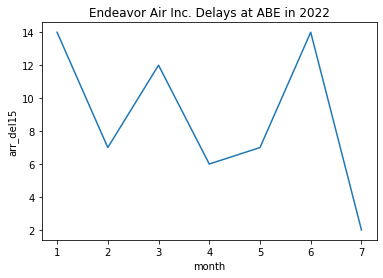

In [19]:
## MADDI
seaborn.lineplot(data=Endeavor_ABE_22_df, x="month", y="arr_del15").set(title='Endeavor Air Inc. Delays at ABE in 2022')

In [26]:
## MADDI
%sql Delta_LAX_Jan_df << SELECT * FROM df_delays WHERE carrier = 'DL' AND airport = 'LAX' AND month = 1
Delta_LAX_Jan_df.head()

Returning data to local variable Delta_LAX_Jan_df


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2022,1,DL,Delta Air Lines Inc.,LAX,"Los Angeles, CA: Los Angeles International",2234.0,287.0,136.97,9.65,...,0.0,51.28,47.0,4.0,22817.0,14467.0,407.0,3570.0,0.0,4373.0
1,2021,1,DL,Delta Air Lines Inc.,LAX,"Los Angeles, CA: Los Angeles International",1844.0,148.0,46.07,0.19,...,1.0,12.08,3.0,2.0,7455.0,3706.0,60.0,2652.0,111.0,926.0
2,2020,1,DL,Delta Air Lines Inc.,LAX,"Los Angeles, CA: Los Angeles International",2893.0,314.0,101.19,12.26,...,0.0,70.57,1.0,0.0,16123.0,6319.0,1566.0,4222.0,0.0,4016.0


(array([2019.75, 2020.  , 2020.25, 2020.5 , 2020.75, 2021.  , 2021.25,
        2021.5 , 2021.75, 2022.  , 2022.25]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

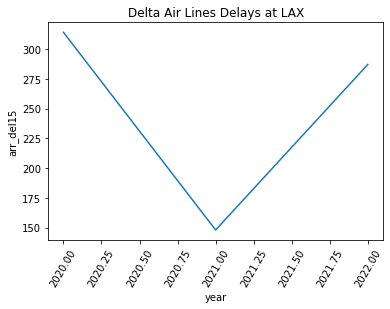

In [31]:
## MADDI
seaborn.lineplot(data=Delta_LAX_Jan_df, x="year", y="arr_del15").set(title='Delta Air Lines Delays at LAX')
plt.xticks(rotation=60)

In [ ]:
## LUCY
%sql df_covid_flight << SELECT 

In [ ]:
## LUCY

In [ ]:
## LUCY

## VI. Questions for reviewers 

### A. Instructions from student handbook
Have an initial dra of your data description section.
Perform and initial exploratory data analysis 
List specific questions for your peer reviewers
and project mentor to answer in giving you feedback on this phase.
